#### <b>QF635 - Market Microstructure - Group Project

- Backtesting RSI strategy on BTCUSDT with different timeframe

In [1]:
# 1.) import necessary libraries and set up the client api

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from binance.client import Client
import ta
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from dateutil.relativedelta import relativedelta

api_key = "qi2dpTQOfXJNfn8XsFv9kNDdmnQxx5MM2WHvwnRNyOTmhLyhUOa4U9Rs9RX5mnZE"
api_secret = "8gDvIDBgMR29rHTUFkcm5MZu0s9hYD8qTcXKlInie9ZP27GyZXcj2dh83benXAhc"
client = Client(api_key, api_secret)

In [2]:
# 2.) all necessary functions

# 2.1) Function to fetch historical data
def get_historical_klines(symbol, interval, start_str, end_str):
    url = "https://api.binance.com/api/v3/klines"
    
    start_ts = int(datetime.timestamp(pd.to_datetime(start_str)) * 1000)
    end_ts = int(datetime.timestamp(pd.to_datetime(end_str)) * 1000) if end_str else None

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts,
        'limit': 1000  # maximum limit
    }
    
    data = []
    
    while True:
        response = requests.get(url, params=params)
        response.raise_for_status()
        klines = response.json()
        
        if not klines:
            break
        
        data += klines
        params['startTime'] = klines[-1][0] + 1  # start from the next timestamp
        
        # Check if we've reached the end timestamp
        if end_ts and params['startTime'] >= end_ts:
            break

    df = pd.DataFrame(data, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 
                                     'close_time', 'quote_asset_volume', 'number_of_trades', 
                                     'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    
    # Convert timestamp to datetime
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
   
    float_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 
                  'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
    df[float_cols] = df[float_cols].astype(float)

    return df

# 2.2) Function to calculate technical indicator
def cal_rsi(data, rsi_period = 14, ma_rsi = 14):
    data['rsi'] = ta.momentum.RSIIndicator(data['close'], rsi_period).rsi()
    data['marsi'] = data['rsi'].rolling(window = ma_rsi).mean()
    return data

def cal_sma(data, window = 100):
    data['sma'] = data['close'].rolling(window = window).mean()
    return data

def cal_atr(data, window = 14, mul_stoploss = 2):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['atr'] = tr.rolling(window=window).mean()
    data['stop_loss_buy'] = data['close'] - (data['atr'] * mul_stoploss)
    data['stop_loss_sell'] = data['close'] + (data['atr'] * mul_stoploss)
    data['middle_price_buy'] = (data['stop_loss_buy'] + data['close']) / 2
    data['middle_price_sell'] = (data['stop_loss_sell'] + data['close']) / 2
    return data

# 2.3) Function to backtest RSI strategy
def ordinary_rsi(coin, rsi_period, ma_rsi, rsi_lower_bound, rsi_upper_bound, sma_window, mul_stoploss, starting_amount, trading_fees):
    coin = coin[["open_time", "open", "high", "low", "close", "volume", "close_time"]]
    coin = cal_rsi(coin, rsi_period, ma_rsi)
    coin = cal_sma(coin, sma_window)
    coin = cal_atr(coin, rsi_period, mul_stoploss)
    coin = coin.dropna()

    position_type = {}
    position_type["E"] = "Empty"
    position_type["B"] = "Buy - First position"
    position_type["BB"] = "Buy - Full position"
    position_type["S"] = "Sell - First position"
    position_type["SS"] = "Sell - Full position"

    portfolio_data = {}
    portfolio_data["timestamp"] = []
    portfolio_data["position type"] = []
    portfolio_data["size"] = []
    portfolio_data["entry_price"] = []
    portfolio_data["market_price"] =[]
    portfolio_data["cash"] = []
    portfolio_data["non-cash"] = []
    portfolio_data["present_val"] = []
    portfolio_data["stop-loss"] =[]
    portfolio_data["second-order"] =[]

    cash = starting_amount
    position = "E"
    size = 0.0
    trading_fees = trading_fees
    entry_price = 0.0

    for index, candle in coin.iterrows():
        if position == "E":
            if candle['rsi'] <= rsi_lower_bound and candle['close'] < candle['sma']:
                position = "B"
                size = ((cash / 2) / candle['close']) - (((cash / 2) / candle['close']) * trading_fees)
                cash = cash - (cash/2)
                entry_price = candle['close']
                non_cash = size * candle['close']
                port_pv = cash + non_cash
                stop_loss = candle["stop_loss_buy"]
                middle_price = candle["middle_price_buy"]

            elif candle['rsi'] >= rsi_upper_bound and candle['close'] > candle['sma']:
                position = "S"
                size = ((cash / 2) / candle['close']) - (((cash/2) / candle['close']) * trading_fees)
                cash = cash - (cash/2)
                entry_price = candle['close']
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = candle["stop_loss_sell"]
                middle_price = candle["middle_price_sell"]

            else:
                position = position
                size = 0
                cash = cash
                entry_price = 0
                non_cash = 0
                port_pv = cash + non_cash
                stop_loss = 0
                middle_price = 0
            
        elif position == "B":
            if candle['close'] <= middle_price and candle['close'] > stop_loss:
                position = "BB"
                entry_price = ((entry_price * size) + (middle_price * ((cash) / middle_price) - (((cash) / middle_price) * trading_fees))) / (size + ((cash) / middle_price) - (((cash) / middle_price) * trading_fees))
                size = size + ((cash) / middle_price) - (((cash) / middle_price) * trading_fees)
                cash = 0
                non_cash = size * candle['close']
                port_pv = cash + non_cash
                stop_loss = stop_loss
                middle_price = middle_price

            elif candle['close'] <= stop_loss:
                position = "E"
                cash = cash + (size * stop_loss - (size * stop_loss * trading_fees)) #candle['close'])
                size = 0
                entry_price = 0
                non_cash = 0
                port_pv = cash + non_cash
                stop_loss = 0
                middle_price = 0

            elif candle['rsi'] >= rsi_upper_bound and candle['close'] > candle['sma']:
                position = "S"
                cash = cash + ((size * candle['close']) - (size * candle['close'] * trading_fees))
                size = ((cash / 2) / candle['close']) - (((cash/2) / candle['close']) * trading_fees)
                cash = cash - (cash/2)
                entry_price = candle['close']
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = candle["stop_loss_sell"]
                middle_price = candle["middle_price_sell"]

            else:
                position = position
                size = size
                cash = cash
                entry_price = entry_price
                non_cash = size * candle['close']
                port_pv = cash + non_cash
                stop_loss = stop_loss
                middle_price = middle_price

        elif position == "BB":
            if candle['rsi'] >= rsi_upper_bound and candle['close'] > candle['sma']:
                position = "S"
                cash = cash + ((size * candle['close']) - (size * candle['close'] * trading_fees))
                size = ((cash / 2) / candle['close']) - (((cash/2) / candle['close']) * trading_fees)
                cash = cash - (cash/2)
                entry_price = candle['close']
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = candle["stop_loss_sell"]
                middle_price = candle["middle_price_sell"]
            
            elif candle['close'] <= stop_loss:
                position = "E"
                cash = cash + (size * stop_loss - (size * stop_loss * trading_fees)) #candle['close'])
                size = 0
                entry_price = 0
                non_cash = 0
                port_pv = cash + non_cash
                stop_loss = 0
                middle_price = 0

            else:
                position = position
                size = size
                cash = cash
                entry_price = entry_price
                non_cash = size * candle['close']
                port_pv = cash + non_cash
                stop_loss = stop_loss
                middle_price = middle_price

        elif position == "S":
            if candle['close'] >= middle_price and candle['close'] < stop_loss: # add another position
                position = "SS"
                entry_price = ((entry_price * size) + (middle_price * ((cash/middle_price) - ((cash/middle_price) * trading_fees)))) / (size + ((cash/middle_price) - ((cash/middle_price) * trading_fees)))
                size = size + ((cash/middle_price) - ((cash/middle_price) * trading_fees))
                cash = 0
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = stop_loss
                middle_price = middle_price

            elif candle['close'] >= stop_loss:
                position = "E"
                cash = cash + (((size * entry_price) - (size * (stop_loss - entry_price))) - (((size * entry_price) - (size * (stop_loss - entry_price))) * trading_fees))
                size = 0
                entry_price = 0
                non_cash = 0
                port_pv = cash + non_cash
                stop_loss = 0
                middle_price = 0

            elif candle['rsi'] <= rsi_lower_bound and candle['close'] < candle['sma']:
                position = "B"
                cash = cash + ((entry_price * size) - (size * (candle['close'] - entry_price))) - (((entry_price * size) - (size * (candle['close'] - entry_price))) * trading_fees)
                size = ((cash / 2) / candle['close']) - (((cash/2) / candle['close']) * trading_fees)
                cash = cash - (cash/2)
                entry_price = candle['close']
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = candle["stop_loss_buy"]
                middle_price = candle["middle_price_buy"]

            else:
                position = position
                size = size
                cash = cash
                entry_price = entry_price
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = stop_loss
                middle_price = middle_price
            
            
        elif position == "SS":

            if candle['rsi'] <= rsi_lower_bound and candle['close'] < candle['sma']:
                position = "B"
                cash  =  cash + ((entry_price * size) - (size * (candle['close'] - entry_price))) - (((entry_price * size) - (size * (candle['close'] - entry_price))) * trading_fees)
                size = ((cash / 2) / candle['close']) - (((cash/2) / candle['close']) * trading_fees)
                cash = cash - (cash/2)
                entry_price = candle['close']
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = candle["stop_loss_buy"]
                middle_price = candle["middle_price_buy"]

            elif candle['close'] >= stop_loss:
                position = "E"
                cash = cash + ((size * entry_price) - (size * (stop_loss - entry_price))) - (((size * entry_price) - (size * (stop_loss - entry_price))) * trading_fees)
                size = 0
                entry_price = 0
                non_cash = 0
                port_pv = cash + non_cash
                stop_loss = 0
                middle_price = 0

            else:
                position = position
                size = size
                cash = cash
                entry_price = entry_price
                non_cash = (size * entry_price) - (size * (candle['close'] - entry_price))
                port_pv = cash + non_cash
                stop_loss = stop_loss
                middle_price = middle_price

        # save order detail
        portfolio_data["timestamp"].append(candle["close_time"])
        portfolio_data["position type"].append(position)
        portfolio_data["size"].append(size)
        portfolio_data["entry_price"].append(entry_price)
        portfolio_data["market_price"].append(candle['close'])
        portfolio_data["cash"].append(cash)
        portfolio_data["non-cash"].append(non_cash)
        portfolio_data["present_val"].append(port_pv)
        portfolio_data["stop-loss"].append(stop_loss)
        portfolio_data["second-order"].append(middle_price)
        
    portfolio_data_df = pd.DataFrame(portfolio_data)
    # coin.to_csv("price_data.csv")
    # portfolio_data_df.to_csv("portfolio_data.csv")
        
    return portfolio_data_df

# 2.4) Function to plot return and calculate performance measurement
# performance measurement

def calculate_pm_st_1(portfolio_data, timeframe, starting_amount):
    portfolio_data['returns'] = portfolio_data['present_val'].pct_change()
    average_return = portfolio_data['returns'].mean()
    volatility = portfolio_data['returns'].std()
    sharpe_ratio = (average_return / volatility) * np.sqrt((365 * 24 * 60) / timeframe)
    cumulative_return = (portfolio_data['present_val'].iloc[-1] / portfolio_data['present_val'].iloc[0]) - 1
    portfolio_data['hold_value'] = starting_amount * (portfolio_data['market_price'] / portfolio_data['market_price'].iloc[0])
    portfolio_data['hold_returns'] = portfolio_data['hold_value'].pct_change()
    buy_and_hold_cumulative_return = (portfolio_data['hold_value'].iloc[-1] / portfolio_data['hold_value'].iloc[0]) - 1

    # max drawdown
    portfolio_data['cum_max'] = portfolio_data['present_val'].cummax()
    portfolio_data['drawdown'] = portfolio_data['present_val'] - portfolio_data['cum_max']
    portfolio_data['drawdown_pct'] = portfolio_data['drawdown'] / portfolio_data['cum_max']
    max_drawdown = portfolio_data['drawdown_pct'].min()

    # num of trade
    # num_trades = 0
    # wins = 0
    # entry_val = None
    # for i in range(1, len(portfolio_data) - 1):
    #     if portfolio_data['position type'].iloc[i] != portfolio_data['position type'].iloc[i-1] and portfolio_data['position type'].iloc[i] not in ["E", "BB", "SS"]:
    #         entry_val = portfolio_data['present_val'].iloc[i]
    #     elif portfolio_data['position type'].iloc[i] != portfolio_data['position type'].iloc[i+1] and portfolio_data['position type'].iloc[i] != "E" and portfolio_data['position type'].iloc[i+1] not in ["E", "BB", "SS"]:
    #         exit_val = portfolio_data['present_val'].iloc[i]
    #         num_trades += 1
    #         if entry_val > exit_val:
    #             wins += 1

    # win_rate = wins / num_trades if num_trades > 0 else 0


    # Calculate buy and hold performance metrics
    hold_average_return = portfolio_data['hold_returns'].mean()
    hold_volatility = portfolio_data['hold_returns'].std()
    hold_sharpe_ratio = (hold_average_return / hold_volatility) * np.sqrt((365 * 24 * 60) / timeframe)
    portfolio_data['hold_cum_max'] = portfolio_data['hold_value'].cummax()
    portfolio_data['hold_drawdown'] = portfolio_data['hold_value'] - portfolio_data['hold_cum_max']
    portfolio_data['hold_drawdown_pct'] = portfolio_data['hold_drawdown'] / portfolio_data['hold_cum_max']
    hold_max_drawdown = portfolio_data['hold_drawdown_pct'].min()

    metrics = {
        'Strategy': ['RSI Strategy', 'Buy and Hold'],
        'Average Return': [average_return, hold_average_return],
        'Volatility': [volatility, hold_volatility],
        'Annualized Sharpe Ratio': [sharpe_ratio, hold_sharpe_ratio],
        'Max Drawdown': [max_drawdown, hold_max_drawdown],
        # 'Number of Trades': [num_trades, 'N/A'],
        # '% Win Rate': [win_rate, 'N/A'],
        'Cumulative Return': [cumulative_return, buy_and_hold_cumulative_return],
        'Portfolio amount' : [portfolio_data['present_val'].iloc[-1], portfolio_data['hold_value'].iloc[-1]]
    }

    metrics_df = pd.DataFrame(metrics)
    plt.figure(figsize=(18, 6))
    plt.plot(portfolio_data['timestamp'], portfolio_data['present_val'], label='RSI Strategy Portfolio Value')
    plt.plot(portfolio_data['timestamp'], portfolio_data['hold_value'], label='Buy and Hold Portfolio Value')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.title('Portfolio Value Over Time')
    plt.grid(True)
    plt.show()

    display(metrics_df)
    return None

##### <b>1.) Fetching Data for training and testing

> Collecting the price data of BTCUSDT. For training dataset we used the candle price data from 01/02/2024 to 30/04/2024 and for testing data we used teh candle price data from 01/05/2024 to 31/05/2024

In [3]:
training_start = "2024-02-01"
training_end = "2024-04-30"

testing_start = "2024-05-01"
testing_end = "2024-05-31"

symbol = "BTCUSDT"

BTC_1m_train = get_historical_klines(symbol, "1m", training_start, training_end)
BTC_3m_train = get_historical_klines(symbol, "3m", training_start, training_end)
BTC_5m_train = get_historical_klines(symbol, "5m", training_start, training_end)

BTC_1m_test = get_historical_klines(symbol, "1m", testing_start, testing_end)
BTC_3m_test = get_historical_klines(symbol, "3m", testing_start, testing_end)
BTC_5m_test = get_historical_klines(symbol, "5m", testing_start, testing_end)

##### <b>2.) Optimizing RSI window and RSI Bound

{'Window': [5], 'Cumulative Ret_1m': [-0.9825428632707841], 'Avg Ret_1m': [-3.1445198583100154e-05], 'Volatility_1m': [0.0005731854778460193], 'Sharpe_1m': [-39.7728618201818], 'Cumulative Ret_3m': [-0.6143144582470443], 'Avg Ret_3m': [-2.1897138665763483e-05], 'Volatility_3m': [0.000955189716722647], 'Sharpe_3m': [-9.59543750390446], 'Cumulative Ret_5m': [-0.3945904334846272], 'Avg Ret_5m': [-1.8924545358446564e-05], 'Volatility_5m': [0.0012084935735711822], 'Sharpe_5m': [-5.077194321619557]}
{'Window': [5, 6], 'Cumulative Ret_1m': [-0.9825428632707841, -0.970536592083942], 'Avg Ret_1m': [-3.1445198583100154e-05, -2.73548064302565e-05], 'Volatility_1m': [0.0005731854778460193, 0.000579145129226681], 'Sharpe_1m': [-39.7728618201818, -34.24316638597146], 'Cumulative Ret_3m': [-0.6143144582470443, -0.5270641686560529], 'Avg Ret_3m': [-2.1897138665763483e-05, -1.71154208549512e-05], 'Volatility_3m': [0.000955189716722647, 0.0009518199121865601], 'Sharpe_3m': [-9.59543750390446, -7.5266175

Window  Cumulative Ret_1m    Avg Ret_1m  Volatility_1m  Sharpe_1m  \
0        5          -0.982543 -3.144520e-05       0.000573 -39.772862   
1        6          -0.970537 -2.735481e-05       0.000579 -34.243166   
2        7          -0.960710 -2.511194e-05       0.000571 -31.885194   
3        8          -0.947680 -2.287430e-05       0.000573 -28.925780   
4        9          -0.931197 -2.073723e-05       0.000571 -26.344081   
..     ...                ...           ...            ...        ...   
91      96          -0.057064 -4.488018e-07       0.000142  -2.295050   
92      97          -0.056881 -4.472903e-07       0.000142  -2.287631   
93      98          -0.056084 -4.404668e-07       0.000143  -2.226931   
94      99          -0.052592 -4.117100e-07       0.000143  -2.089145   
95     100          -0.052447 -4.105214e-07       0.000143  -2.083412   

    Cumulative Ret_3m    Avg Ret_3m  Volatility_3m  Sharpe_3m  \
0           -0.614314 -2.189714e-05       0.000955  -9.595438   
1           -0.527064 -1.711542e-05       0.000952  -7.526618   
2           -0.543119 -1.794628e-05       0.000930  -8.075894   
3           -0.438111 -1.308979e-05       0.000933  -5.872704   
4           -0.332800 -9.069727e-06       0.000922  -4.118912   
..                ...           ...            ...        ...   
91          -0.022597 -5.096536e-07       0.000231  -0.922747   
92          -0.019045 -4.247001e-07       0.000231  -0.771057   
93          -0.018986 -4.233057e-07       0.000230  -0.768754   
94          -0.018900 -4.212619e-07       0.000230  -0.765189   
95          -0.018904 -4.213560e-07       0.000230  -0.765217   

    Cumulative Ret_5m    Avg Ret_5m  Volatility_5m  Sharpe_5m  
0           -0.394590 -1.892455e-05       0.001208  -5.077194  
1           -0.342318 -1.567456e-05       0.001214  -4.185704  
2           -0.312988 -1.397767e-05       0.001204  -3.762958  
3           -0.255153 -1.082670e-05       0.001192  -2.944298  
4           -0.231074 -9.604051e-06       0.001172  -2.656347  
..                ...           ...            ...        ...  
91          -0.030589 -1.133339e-06       0.000410  -0.896158  
92          -0.030524 -1.130769e-06       0.000410  -0.894176  
93          -0.030466 -1.128495e-06       0.000410  -0.892488  
94          -0.023844 -8.635659e-07       0.000406  -0.690173  
95          -0.023797 -8.617102e-07       0.000406  -0.688759  

[96 rows x 13 columns]

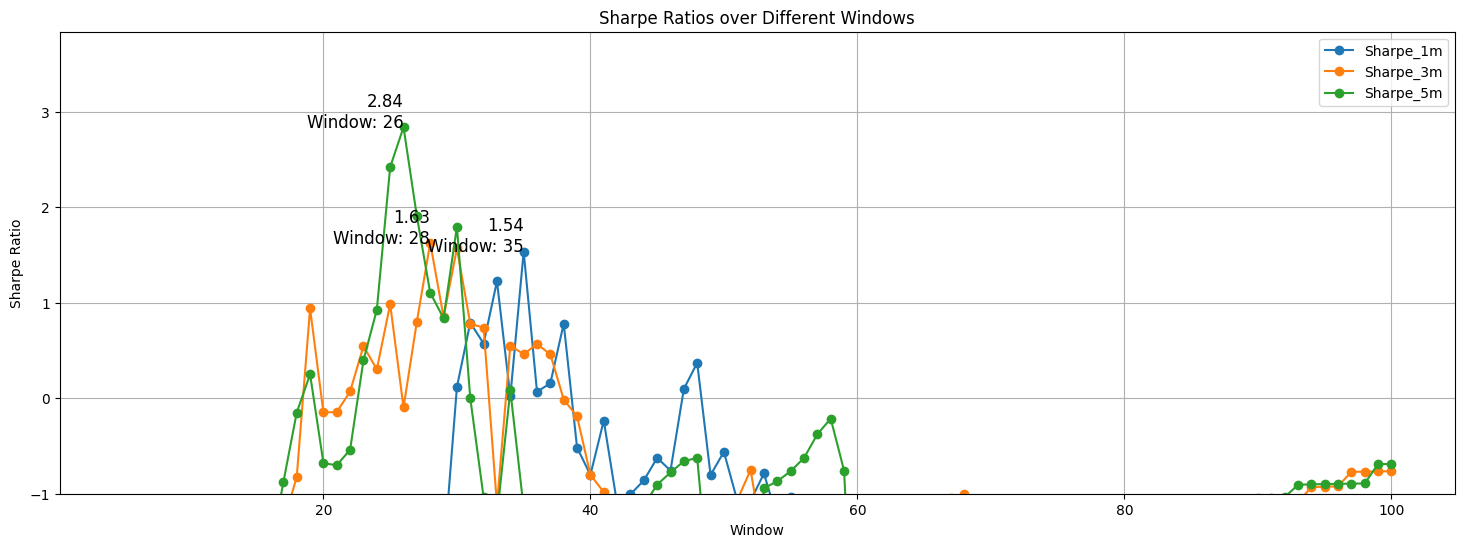

In [4]:
opt_dict = {}
opt_dict["Window"] = []
opt_dict["Cumulative Ret_1m"] = []
opt_dict["Avg Ret_1m"] = []
opt_dict["Volatility_1m"] = []
opt_dict["Sharpe_1m"] = []
opt_dict["Cumulative Ret_3m"] = []
opt_dict["Avg Ret_3m"] = []
opt_dict["Volatility_3m"] = []
opt_dict["Sharpe_3m"] = []
opt_dict["Cumulative Ret_5m"] = []
opt_dict["Avg Ret_5m"] = []
opt_dict["Volatility_5m"] = []
opt_dict["Sharpe_5m"] = []

for i in range(5,101):

    opt_dict["Window"].append(i)
    st_return_1 = ordinary_rsi(BTC_1m_train, rsi_period = i, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
    st_return_3 = ordinary_rsi(BTC_3m_train, rsi_period = i, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
    st_return_5 = ordinary_rsi(BTC_5m_train, rsi_period = i, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)

    st_return_1['returns'] = st_return_1['present_val'].pct_change()
    average_return_1 = st_return_1['returns'].mean()
    volatility_1 = st_return_1['returns'].std()
    sharpe_ratio_1 = (average_return_1 / volatility_1) * np.sqrt((365 * 24 * 60) / 1)
    cumulative_return_1 = (st_return_1['present_val'].iloc[-1] / st_return_1['present_val'].iloc[0]) - 1

    st_return_3['returns'] = st_return_3['present_val'].pct_change()
    average_return_3 = st_return_3['returns'].mean()
    volatility_3 = st_return_3['returns'].std()
    sharpe_ratio_3 = (average_return_3 / volatility_3) * np.sqrt((365 * 24 * 60) / 3)
    cumulative_return_3 = (st_return_3['present_val'].iloc[-1] / st_return_3['present_val'].iloc[0]) - 1

    st_return_5['returns'] = st_return_5['present_val'].pct_change()
    average_return_5 = st_return_5['returns'].mean()
    volatility_5 = st_return_5['returns'].std()
    sharpe_ratio_5 = (average_return_5 / volatility_5) * np.sqrt((365 * 24 * 60) / 5)
    cumulative_return_5 = (st_return_5['present_val'].iloc[-1] / st_return_5['present_val'].iloc[0]) - 1

    opt_dict["Cumulative Ret_1m"].append(cumulative_return_1)
    opt_dict["Avg Ret_1m"].append(average_return_1)
    opt_dict["Volatility_1m"].append(volatility_1)
    opt_dict["Sharpe_1m"].append(sharpe_ratio_1)

    opt_dict["Cumulative Ret_3m"].append(cumulative_return_3)
    opt_dict["Avg Ret_3m"].append(average_return_3)
    opt_dict["Volatility_3m"].append(volatility_3)
    opt_dict["Sharpe_3m"].append(sharpe_ratio_3)

    opt_dict["Cumulative Ret_5m"].append(cumulative_return_5)
    opt_dict["Avg Ret_5m"].append(average_return_5)
    opt_dict["Volatility_5m"].append(volatility_5)
    opt_dict["Sharpe_5m"].append(sharpe_ratio_5)

    print(opt_dict)

result = pd.DataFrame(opt_dict)
display(result)

# Plotting the data
plt.figure(figsize=(18, 6))
plt.plot(result['Window'], result['Sharpe_1m'], label='Sharpe_1m', marker='o')
plt.plot(result['Window'], result['Sharpe_3m'], label='Sharpe_3m', marker='o')
plt.plot(result['Window'], result['Sharpe_5m'], label='Sharpe_5m', marker='o')

# Adding text at the highest point of each line
max_sharpe_1m = result['Sharpe_1m'].max()
max_sharpe_3m = result['Sharpe_3m'].max()
max_sharpe_5m = result['Sharpe_5m'].max()

max_1m_idx = result['Sharpe_1m'].idxmax()
max_3m_idx = result['Sharpe_3m'].idxmax()
max_5m_idx = result['Sharpe_5m'].idxmax()

plt.text(result['Window'][max_1m_idx], max_sharpe_1m, f'{max_sharpe_1m:.2f}\nWindow: {result["Window"][max_1m_idx]}', fontsize=12, ha='right')
plt.text(result['Window'][max_3m_idx], max_sharpe_3m, f'{max_sharpe_3m:.2f}\nWindow: {result["Window"][max_3m_idx]}', fontsize=12, ha='right')
plt.text(result['Window'][max_5m_idx], max_sharpe_5m, f'{max_sharpe_5m:.2f}\nWindow: {result["Window"][max_5m_idx]}', fontsize=12, ha='right')

# Setting y-axis limit from -1 upwards
plt.ylim(-1, max(max_sharpe_1m, max_sharpe_3m, max_sharpe_5m) + 1)

plt.xlabel('Window')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios over Different Windows')
plt.legend()
plt.grid(True)
plt.show()

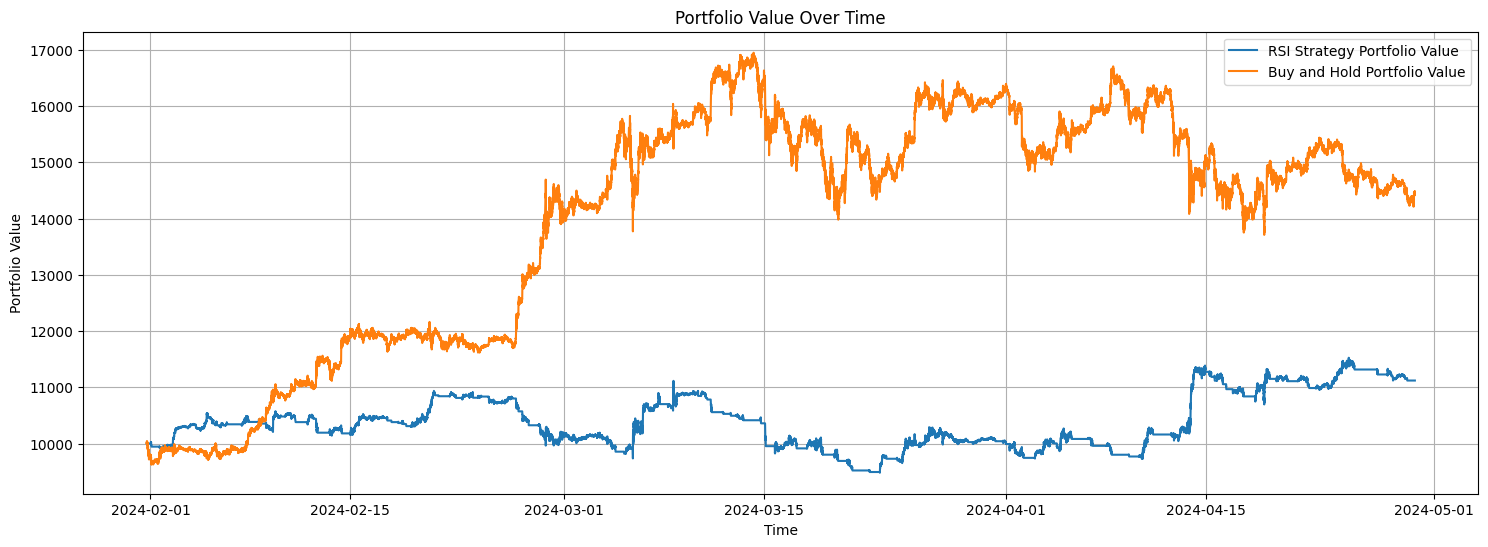

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy    9.244958e-07    0.000436                 1.536215   
1  Buy and Hold    3.240775e-06    0.000841                 2.793532   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.146939           0.112057      11120.568623  
1     -0.191073           0.447305      14473.052766

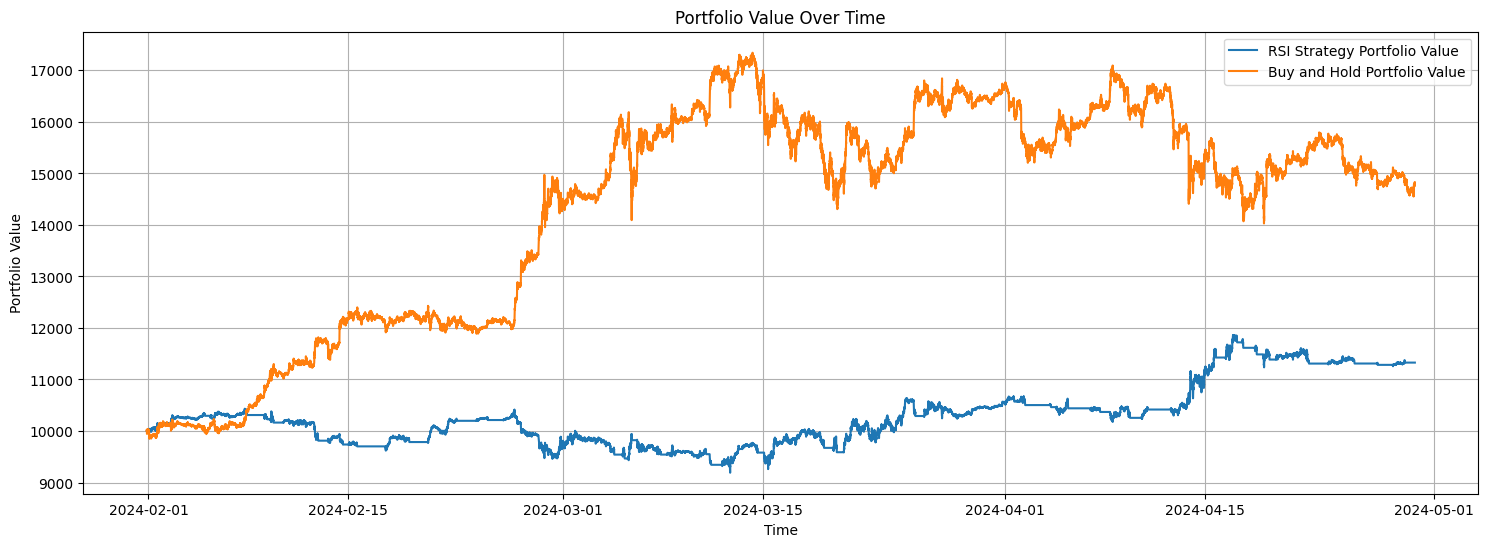

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000003    0.000844                 1.627160   
1  Buy and Hold        0.000010    0.001446                 2.976865   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.119065           0.132767      11327.667553  
1     -0.191073           0.482553      14825.531403

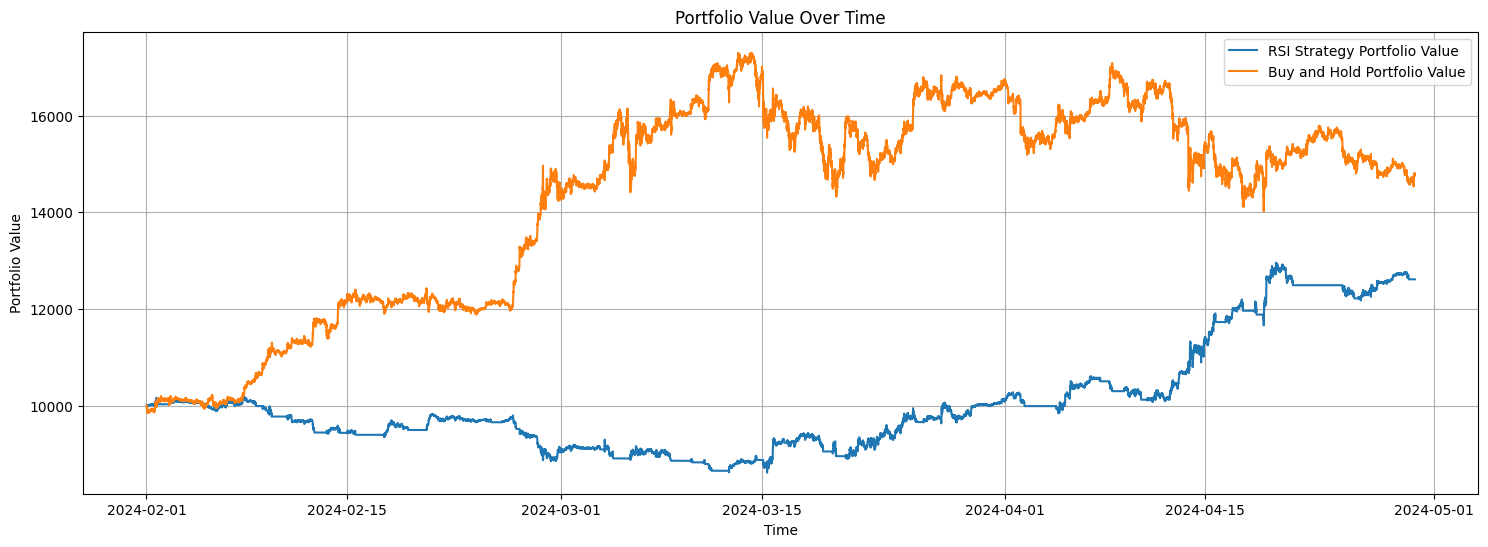

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000010    0.001108                 2.839421   
1  Buy and Hold        0.000017    0.001840                 3.005922   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.157253           0.261295      12612.948091  
1     -0.189457           0.480395      14803.948932

In [6]:
# Training data

BTC_1m_op1_train = ordinary_rsi(BTC_1m_train, rsi_period = 35, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_1m_op1_train, timeframe = 1, starting_amount= 10000)

BTC_3m_op1_train = ordinary_rsi(BTC_3m_train, rsi_period = 28, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_3m_op1_train, timeframe = 3, starting_amount= 10000)

BTC_5m_op1_train = ordinary_rsi(BTC_5m_train, rsi_period = 26, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_5m_op1_train, timeframe = 5, starting_amount= 10000)

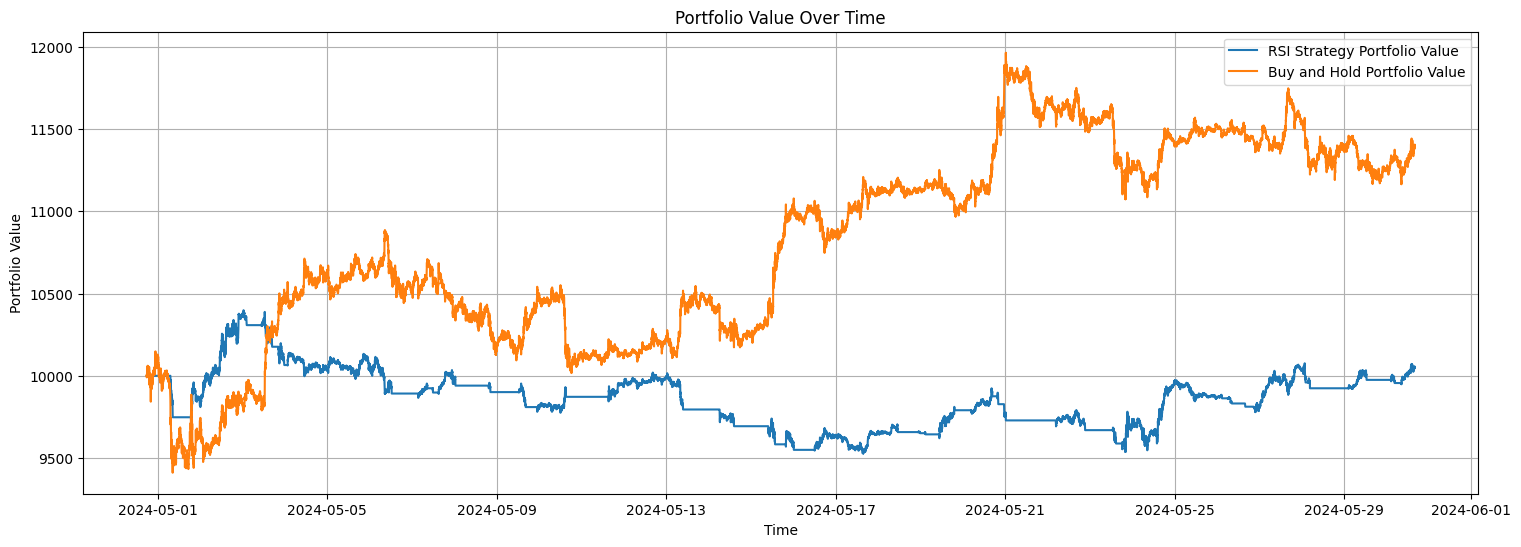

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy    1.803866e-07    0.000338                 0.387232   
1  Buy and Hold    3.252293e-06    0.000652                 3.616906   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.083758           0.005331      10053.309484  
1     -0.079771           0.139990      11399.903854

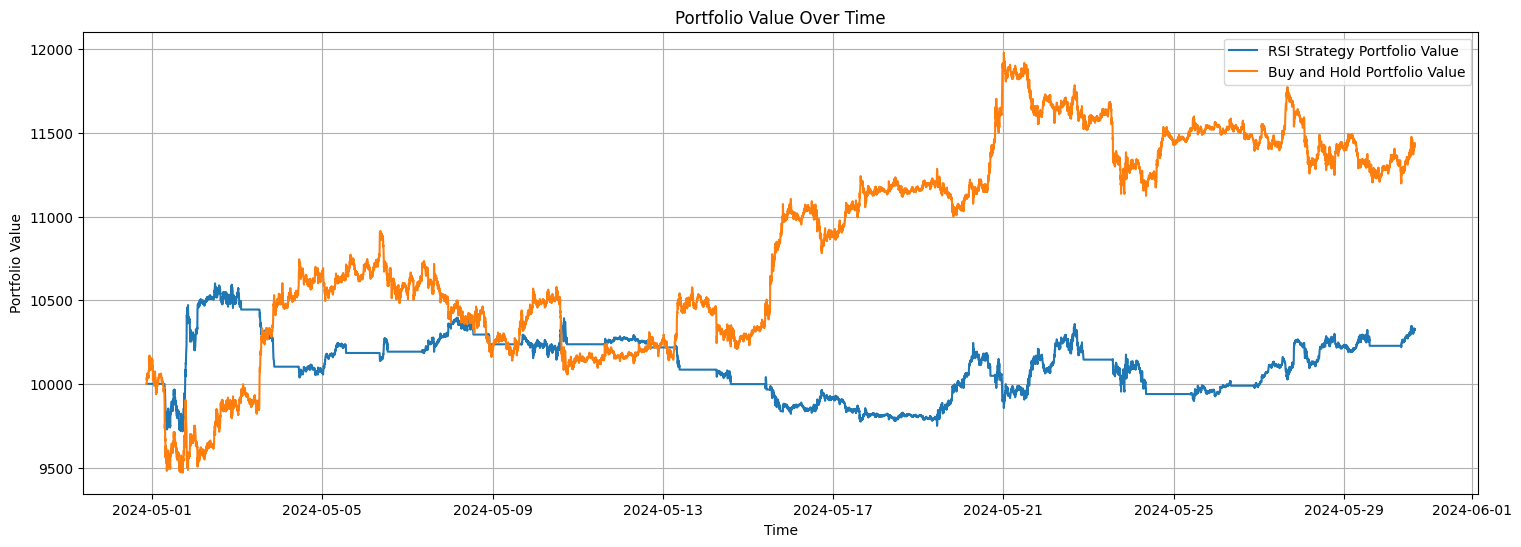

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000002    0.000685                 1.516038   
1  Buy and Hold        0.000010    0.001103                 3.783397   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.080371           0.032670      10326.700917  
1     -0.078545           0.143255      11432.551316

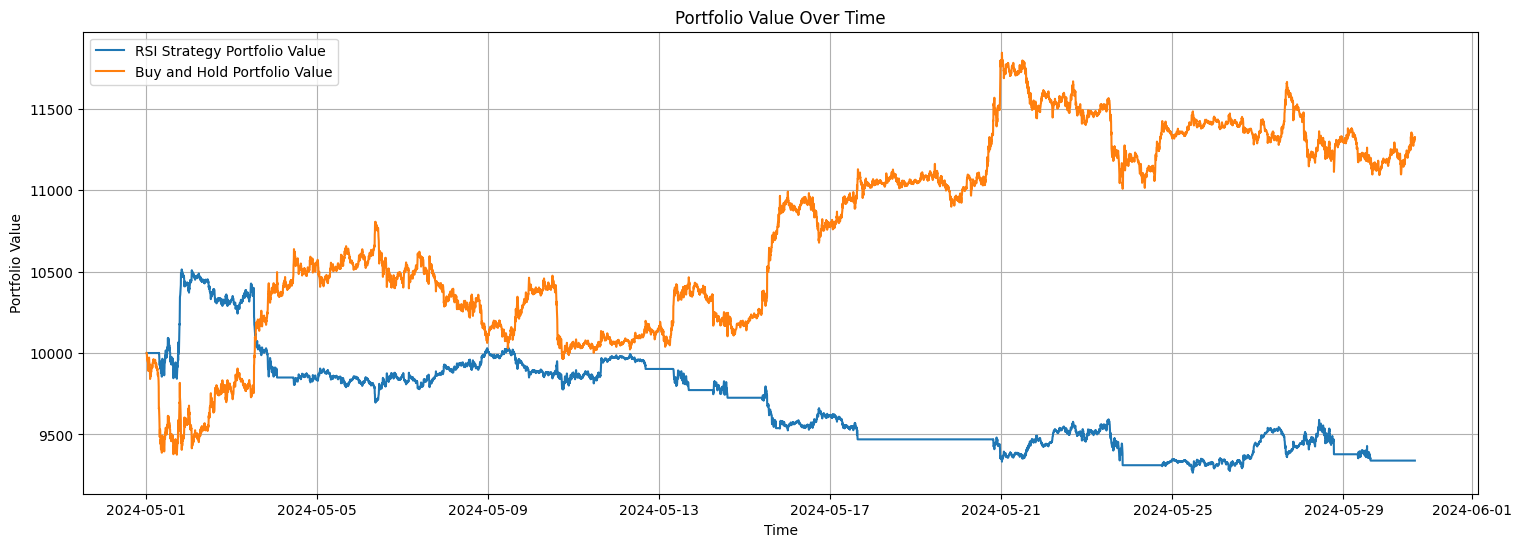

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy       -0.000008    0.000809                -3.075992   
1  Buy and Hold        0.000016    0.001409                 3.581658   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.118767          -0.066074       9339.264180  
1     -0.078068           0.132581      11325.807298

In [7]:
# Testing data

BTC_1m_op1_test = ordinary_rsi(BTC_1m_test, rsi_period = 35, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_1m_op1_test, timeframe = 1, starting_amount= 10000)

BTC_3m_op1_test = ordinary_rsi(BTC_3m_test, rsi_period = 28, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_3m_op1_test, timeframe = 3, starting_amount= 10000)

BTC_5m_op1_test = ordinary_rsi(BTC_5m_test, rsi_period = 26, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 70, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_5m_op1_test, timeframe = 5, starting_amount= 10000)

In [8]:
#Finding the optimised upper and lower bound RSI level
opt_dict_2 = {}
opt_dict_2["Lower Bound"] = []
opt_dict_2["Upper Bound"] = []
opt_dict_2["Cumulative Ret_1m"] = []
opt_dict_2["Avg Ret_1m"] = []
opt_dict_2["Volatility_1m"] = []
opt_dict_2["Sharpe_1m"] = []
opt_dict_2["Cumulative Ret_3m"] = []
opt_dict_2["Avg Ret_3m"] = []
opt_dict_2["Volatility_3m"] = []
opt_dict_2["Sharpe_3m"] = []
opt_dict_2["Cumulative Ret_5m"] = []
opt_dict_2["Avg Ret_5m"] = []
opt_dict_2["Volatility_5m"] = []
opt_dict_2["Sharpe_5m"] = []

# Define the range of values for optimization
rsi_lower_bound_range = range(10, 50, 5)  # Example range: 10 to 36 with a step of 2
rsi_upper_bound_range = range(50, 100, 5)  # Example range: 65 to 91 with a step of 2

# Loop through each combination of rsi_lower_bound and rsi_upper_bound
for lower_bound in rsi_lower_bound_range:
    for upper_bound in rsi_upper_bound_range:
        opt_dict_2["Lower Bound"].append(lower_bound)
        opt_dict_2["Upper Bound"].append(upper_bound)

        st_return_1 = ordinary_rsi(BTC_1m_train, rsi_period = 35, ma_rsi = 14, rsi_lower_bound = lower_bound, rsi_upper_bound = upper_bound, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
        st_return_3 = ordinary_rsi(BTC_3m_train, rsi_period = 28, ma_rsi = 14, rsi_lower_bound = lower_bound, rsi_upper_bound = upper_bound, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
        st_return_5 = ordinary_rsi(BTC_5m_train, rsi_period = 26, ma_rsi = 14, rsi_lower_bound = lower_bound, rsi_upper_bound = upper_bound, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)

        st_return_1['returns'] = st_return_1['present_val'].pct_change()
        average_return_1 = st_return_1['returns'].mean()
        volatility_1 = st_return_1['returns'].std()
        sharpe_ratio_1 = (average_return_1 / volatility_1) * np.sqrt((365 * 24 * 60) / 1)
        cumulative_return_1 = (st_return_1['present_val'].iloc[-1] / st_return_1['present_val'].iloc[0]) - 1

        st_return_3['returns'] = st_return_3['present_val'].pct_change()
        average_return_3 = st_return_3['returns'].mean()
        volatility_3 = st_return_3['returns'].std()
        sharpe_ratio_3 = (average_return_3 / volatility_3) * np.sqrt((365 * 24 * 60) / 3)
        cumulative_return_3 = (st_return_3['present_val'].iloc[-1] / st_return_3['present_val'].iloc[0]) - 1

        st_return_5['returns'] = st_return_5['present_val'].pct_change()
        average_return_5 = st_return_5['returns'].mean()
        volatility_5 = st_return_5['returns'].std()
        sharpe_ratio_5 = (average_return_5 / volatility_5) * np.sqrt((365 * 24 * 60) / 5)
        cumulative_return_5 = (st_return_5['present_val'].iloc[-1] / st_return_5['present_val'].iloc[0]) - 1

        opt_dict_2["Cumulative Ret_1m"].append(cumulative_return_1)
        opt_dict_2["Avg Ret_1m"].append(average_return_1)
        opt_dict_2["Volatility_1m"].append(volatility_1)
        opt_dict_2["Sharpe_1m"].append(sharpe_ratio_1)

        opt_dict_2["Cumulative Ret_3m"].append(cumulative_return_3)
        opt_dict_2["Avg Ret_3m"].append(average_return_3)
        opt_dict_2["Volatility_3m"].append(volatility_3)
        opt_dict_2["Sharpe_3m"].append(sharpe_ratio_3)

        opt_dict_2["Cumulative Ret_5m"].append(cumulative_return_5)
        opt_dict_2["Avg Ret_5m"].append(average_return_5)
        opt_dict_2["Volatility_5m"].append(volatility_5)
        opt_dict_2["Sharpe_5m"].append(sharpe_ratio_5)

        print(opt_dict_2)

result_2 = pd.DataFrame(opt_dict_2)

{'Lower Bound': [10], 'Upper Bound': [50], 'Cumulative Ret_1m': [-0.23093390203038722], 'Avg Ret_1m': [-1.8558595812240926e-06], 'Volatility_1m': [0.0006238930814898633], 'Sharpe_1m': [-2.1565653448424422], 'Cumulative Ret_3m': [-0.2428970106343754], 'Avg Ret_3m': [-5.898686464412965e-06], 'Volatility_3m': [0.0011228296754641463], 'Sharpe_3m': [-2.198915199686256], 'Cumulative Ret_5m': [-0.21468901886203517], 'Avg Ret_5m': [-8.403484703349649e-06], 'Volatility_5m': [0.001457865708717517], 'Sharpe_5m': [-1.868893567264355]}
{'Lower Bound': [10, 10], 'Upper Bound': [50, 55], 'Cumulative Ret_1m': [-0.23093390203038722, -0.22899597111239267], 'Avg Ret_1m': [-1.8558595812240926e-06, -1.8311351430772948e-06], 'Volatility_1m': [0.0006238930814898633, 0.0006319712582385946], 'Sharpe_1m': [-2.1565653448424422, -2.100635732644122], 'Cumulative Ret_3m': [-0.2428970106343754, -0.2429093229647704], 'Avg Ret_3m': [-5.898686464412965e-06, -5.899072647423957e-06], 'Volatility_3m': [0.00112282967546414

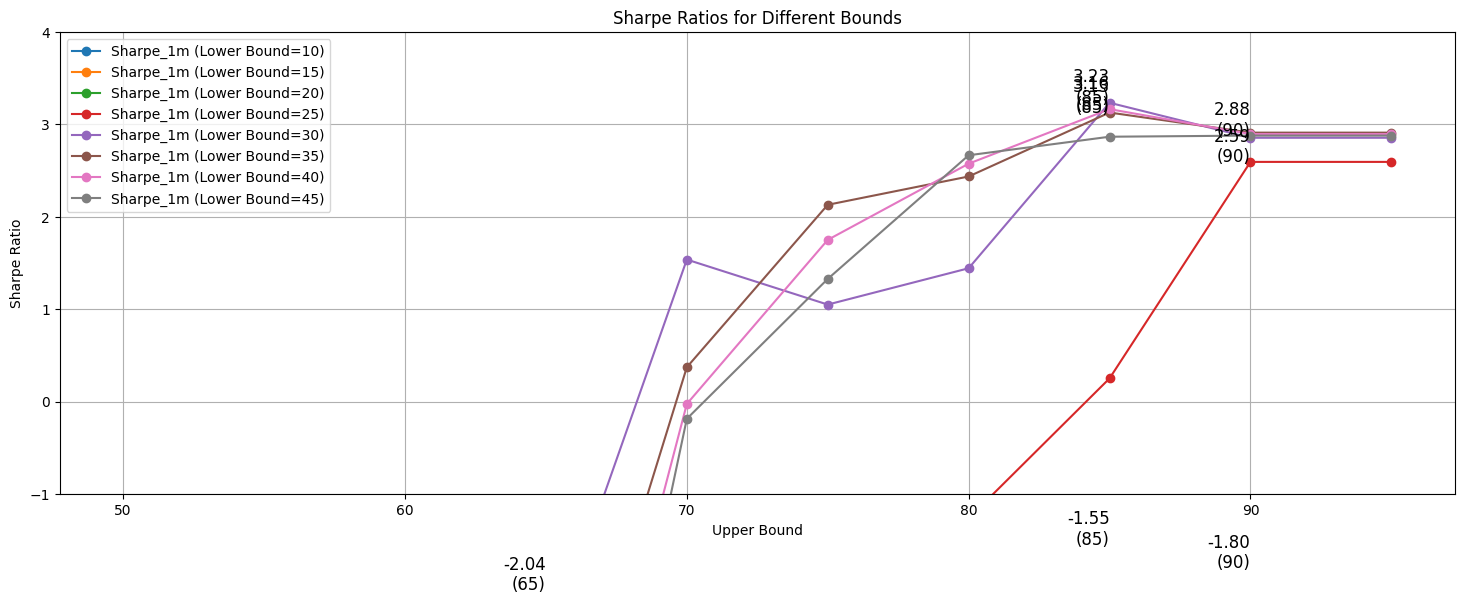

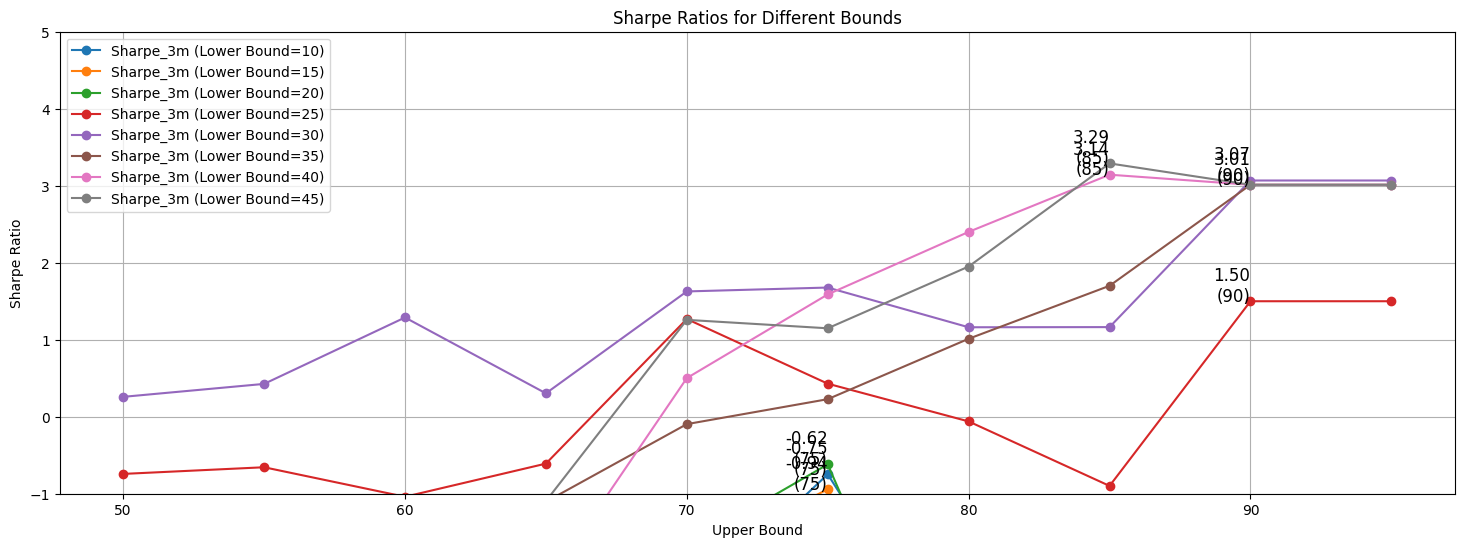

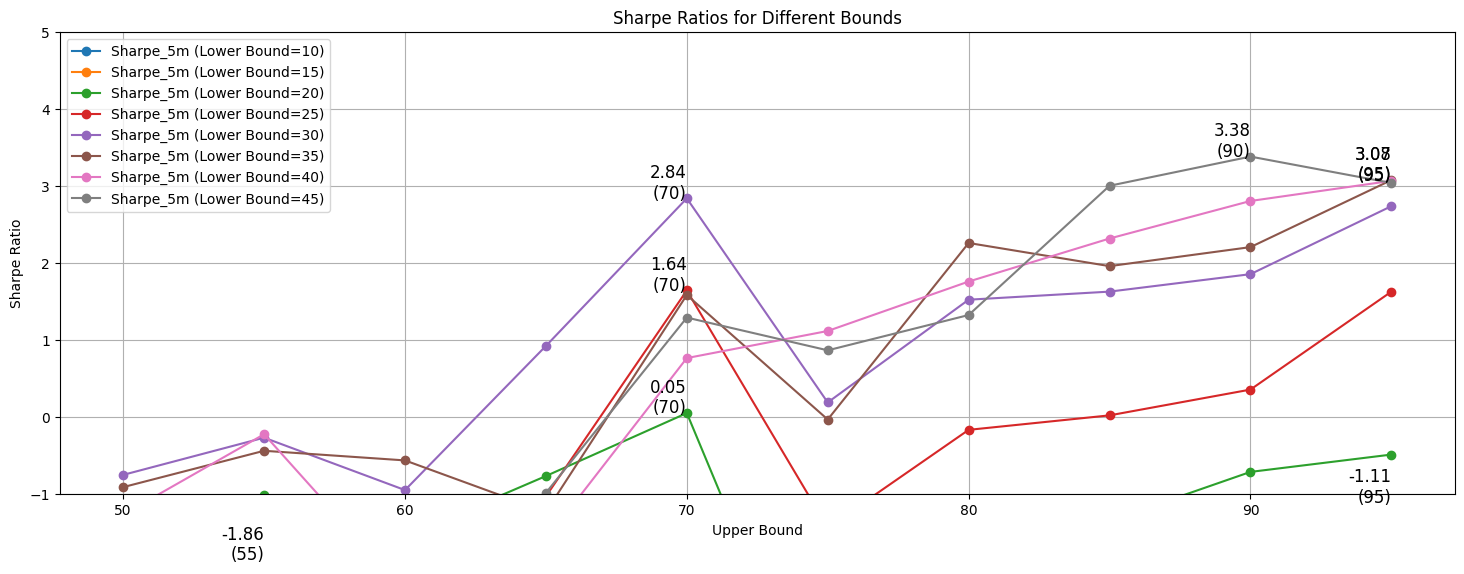

In [9]:
# Plotting the data
plt.figure(figsize=(18, 6))
for lower_bound in result_2['Lower Bound'].unique():
    subset = result_2[result_2['Lower Bound'] == lower_bound]
    plt.plot(subset['Upper Bound'], subset['Sharpe_1m'], label=f'Sharpe_1m (Lower Bound={lower_bound})', marker='o')
    # plt.plot(subset['Upper Bound'], subset['Sharpe_3m'], label=f'Sharpe_3m (Lower Bound={lower_bound})', marker='o')
    # plt.plot(subset['Upper Bound'], subset['Sharpe_5m'], label=f'Sharpe_5m (Lower Bound={lower_bound})', marker='o')
    
    # Adding text at the highest point of each line
    max_sharpe_1m = subset['Sharpe_1m'].max()
    # max_sharpe_3m = subset['Sharpe_3m'].max()
    # max_sharpe_5m = subset['Sharpe_5m'].max()

    max_1m_idx = subset['Sharpe_1m'].idxmax()
    # max_3m_idx = subset['Sharpe_3m'].idxmax()
    # max_5m_idx = subset['Sharpe_5m'].idxmax()

    plt.text(subset['Upper Bound'][max_1m_idx], max_sharpe_1m, f'{max_sharpe_1m:.2f}\n({subset["Upper Bound"][max_1m_idx]})', fontsize=12, ha='right')
    # plt.text(subset['Upper Bound'][max_3m_idx], max_sharpe_3m, f'{max_sharpe_3m:.2f}\n({subset["Upper Bound"][max_3m_idx]})', fontsize=12, ha='right')
    # plt.text(subset['Upper Bound'][max_5m_idx], max_sharpe_5m, f'{max_sharpe_5m:.2f}\n({subset["Upper Bound"][max_5m_idx]})', fontsize=12, ha='right')

plt.xlabel('Upper Bound')
plt.ylim(-1, 4)
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios for Different Bounds')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 6))
for lower_bound in result_2['Lower Bound'].unique():
    subset = result_2[result_2['Lower Bound'] == lower_bound]
    # plt.plot(subset['Upper Bound'], subset['Sharpe_1m'], label=f'Sharpe_1m (Lower Bound={lower_bound})', marker='o')
    plt.plot(subset['Upper Bound'], subset['Sharpe_3m'], label=f'Sharpe_3m (Lower Bound={lower_bound})', marker='o')
    # plt.plot(subset['Upper Bound'], subset['Sharpe_5m'], label=f'Sharpe_5m (Lower Bound={lower_bound})', marker='o')
    
    # Adding text at the highest point of each line
    # max_sharpe_1m = subset['Sharpe_1m'].max()
    max_sharpe_3m = subset['Sharpe_3m'].max()
    # max_sharpe_5m = subset['Sharpe_5m'].max()

    # max_1m_idx = subset['Sharpe_1m'].idxmax()
    max_3m_idx = subset['Sharpe_3m'].idxmax()
    # max_5m_idx = subset['Sharpe_5m'].idxmax()

    # plt.text(subset['Upper Bound'][max_1m_idx], max_sharpe_1m, f'{max_sharpe_1m:.2f}\n({subset["Upper Bound"][max_1m_idx]})', fontsize=12, ha='right')
    plt.text(subset['Upper Bound'][max_3m_idx], max_sharpe_3m, f'{max_sharpe_3m:.2f}\n({subset["Upper Bound"][max_3m_idx]})', fontsize=12, ha='right')
    # plt.text(subset['Upper Bound'][max_5m_idx], max_sharpe_5m, f'{max_sharpe_5m:.2f}\n({subset["Upper Bound"][max_5m_idx]})', fontsize=12, ha='right')

plt.xlabel('Upper Bound')
plt.ylim(-1, 5)
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios for Different Bounds')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 6))
for lower_bound in result_2['Lower Bound'].unique():
    subset = result_2[result_2['Lower Bound'] == lower_bound]
    # plt.plot(subset['Upper Bound'], subset['Sharpe_1m'], label=f'Sharpe_1m (Lower Bound={lower_bound})', marker='o')
    # plt.plot(subset['Upper Bound'], subset['Sharpe_3m'], label=f'Sharpe_3m (Lower Bound={lower_bound})', marker='o')
    plt.plot(subset['Upper Bound'], subset['Sharpe_5m'], label=f'Sharpe_5m (Lower Bound={lower_bound})', marker='o')
    
    # Adding text at the highest point of each line
    # max_sharpe_1m = subset['Sharpe_1m'].max()
    # max_sharpe_3m = subset['Sharpe_3m'].max()
    max_sharpe_5m = subset['Sharpe_5m'].max()

    # max_1m_idx = subset['Sharpe_1m'].idxmax()
    # max_3m_idx = subset['Sharpe_3m'].idxmax()
    max_5m_idx = subset['Sharpe_5m'].idxmax()

    # plt.text(subset['Upper Bound'][max_1m_idx], max_sharpe_1m, f'{max_sharpe_1m:.2f}\n({subset["Upper Bound"][max_1m_idx]})', fontsize=12, ha='right')
    # plt.text(subset['Upper Bound'][max_3m_idx], max_sharpe_3m, f'{max_sharpe_3m:.2f}\n({subset["Upper Bound"][max_3m_idx]})', fontsize=12, ha='right')
    plt.text(subset['Upper Bound'][max_5m_idx], max_sharpe_5m, f'{max_sharpe_5m:.2f}\n({subset["Upper Bound"][max_5m_idx]})', fontsize=12, ha='right')

plt.xlabel('Upper Bound')
plt.ylim(-1, 5)
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios for Different Bounds')
plt.legend()
plt.grid(True)
plt.show()

##### <b>3.) Result of optimal RSI Strategy

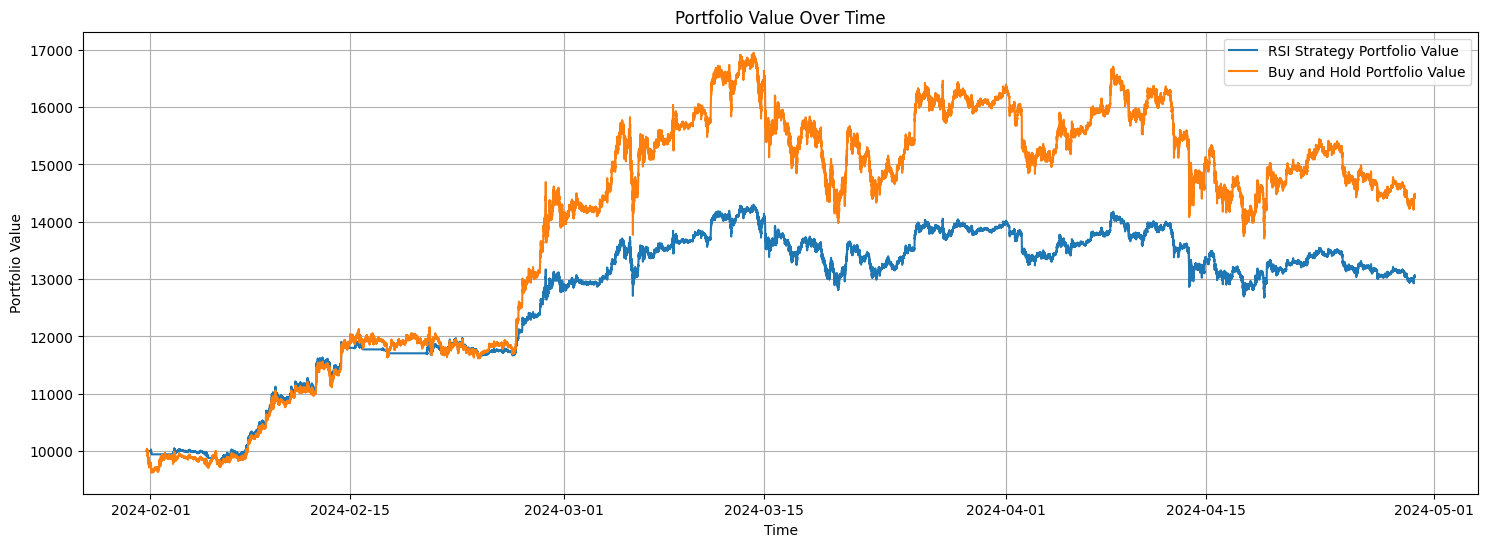

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000002    0.000495                 3.233344   
1  Buy and Hold        0.000003    0.000841                 2.793532   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.113341           0.305925      13059.249047  
1     -0.191073           0.447305      14473.052766

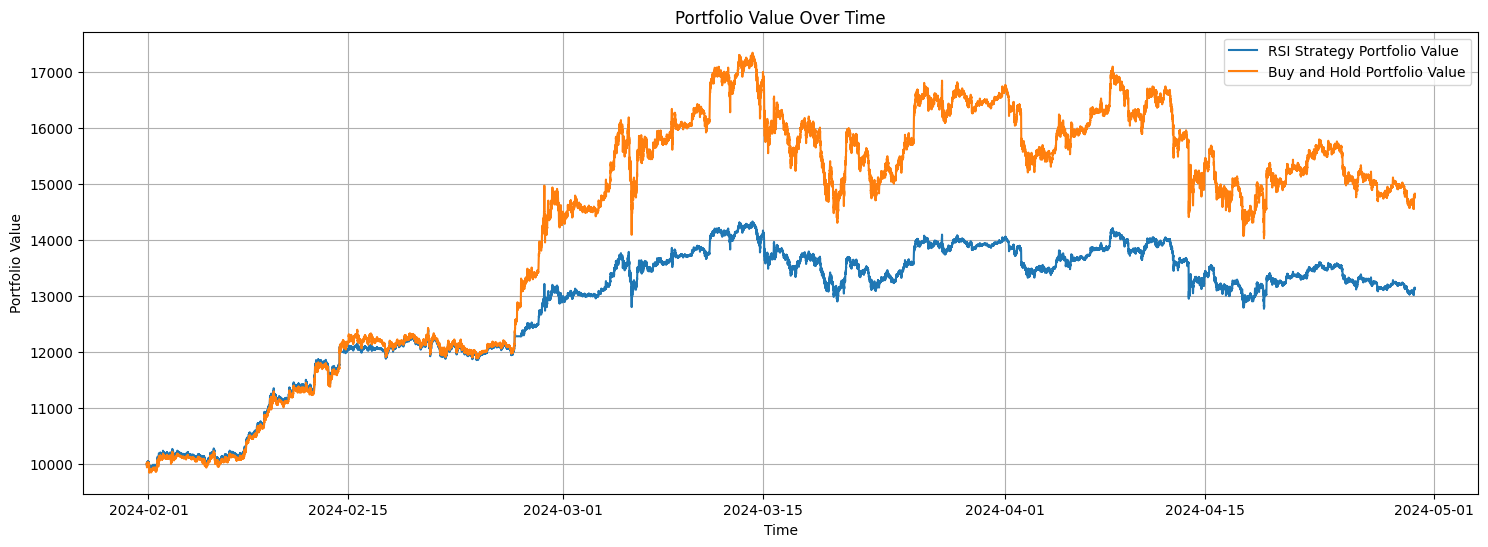

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000007    0.000865                 3.289776   
1  Buy and Hold        0.000010    0.001446                 2.976865   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.108692           0.315129      13148.003572  
1     -0.191073           0.482553      14825.531403

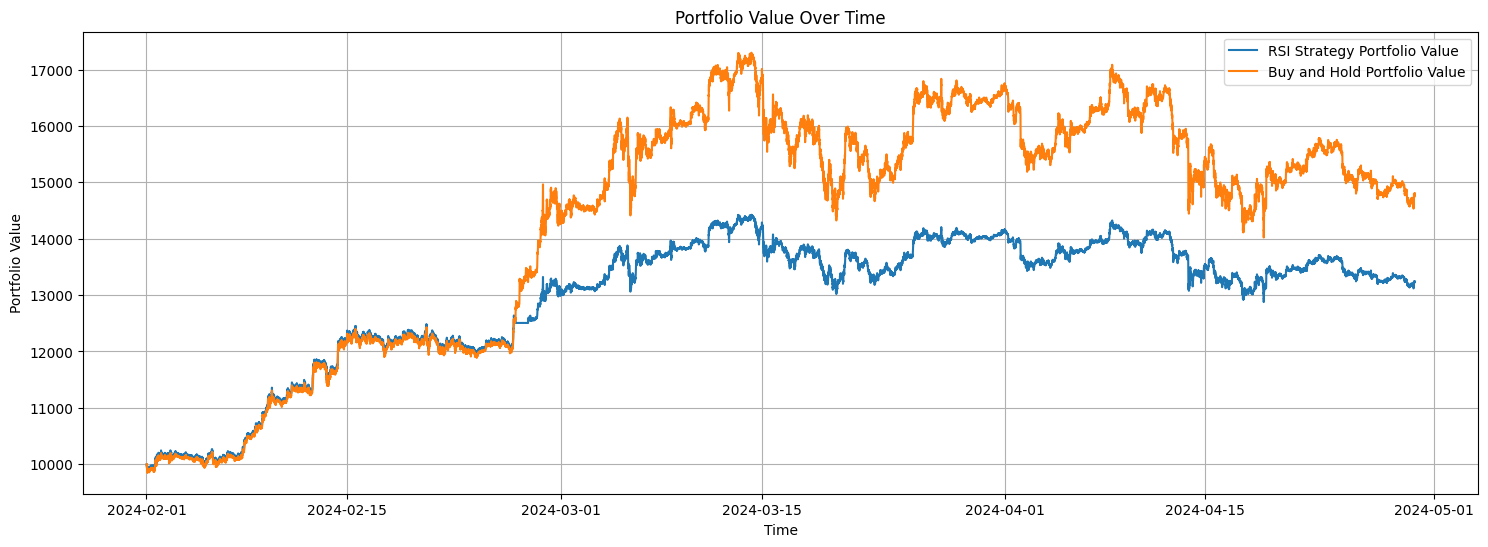

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000012    0.001116                 3.381993   
1  Buy and Hold        0.000017    0.001840                 3.005922   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.107327           0.324903      13245.716699  
1     -0.189457           0.480395      14803.948932

In [10]:
# Training data

BTC_1m_op1_train = ordinary_rsi(BTC_1m_train, rsi_period = 35, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 85, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_1m_op1_train, timeframe = 1, starting_amount= 10000)

BTC_3m_op1_train = ordinary_rsi(BTC_3m_train, rsi_period = 28, ma_rsi = 14, rsi_lower_bound = 45, rsi_upper_bound = 85, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_3m_op1_train, timeframe = 3, starting_amount= 10000)

BTC_5m_op1_train = ordinary_rsi(BTC_5m_train, rsi_period = 26, ma_rsi = 14, rsi_lower_bound = 45, rsi_upper_bound = 90, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_5m_op1_train, timeframe = 5, starting_amount= 10000)

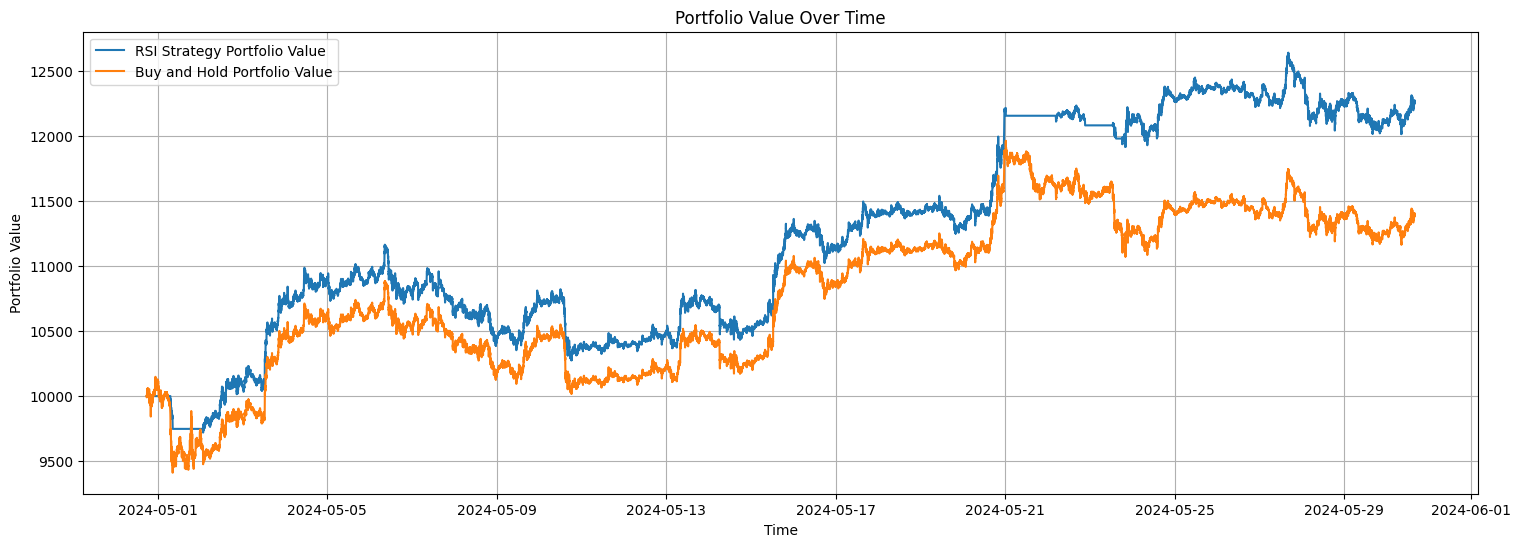

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000005    0.000571                 6.223529   
1  Buy and Hold        0.000003    0.000652                 3.616906   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.079771           0.226802      12268.017081  
1     -0.079771           0.139990      11399.903854

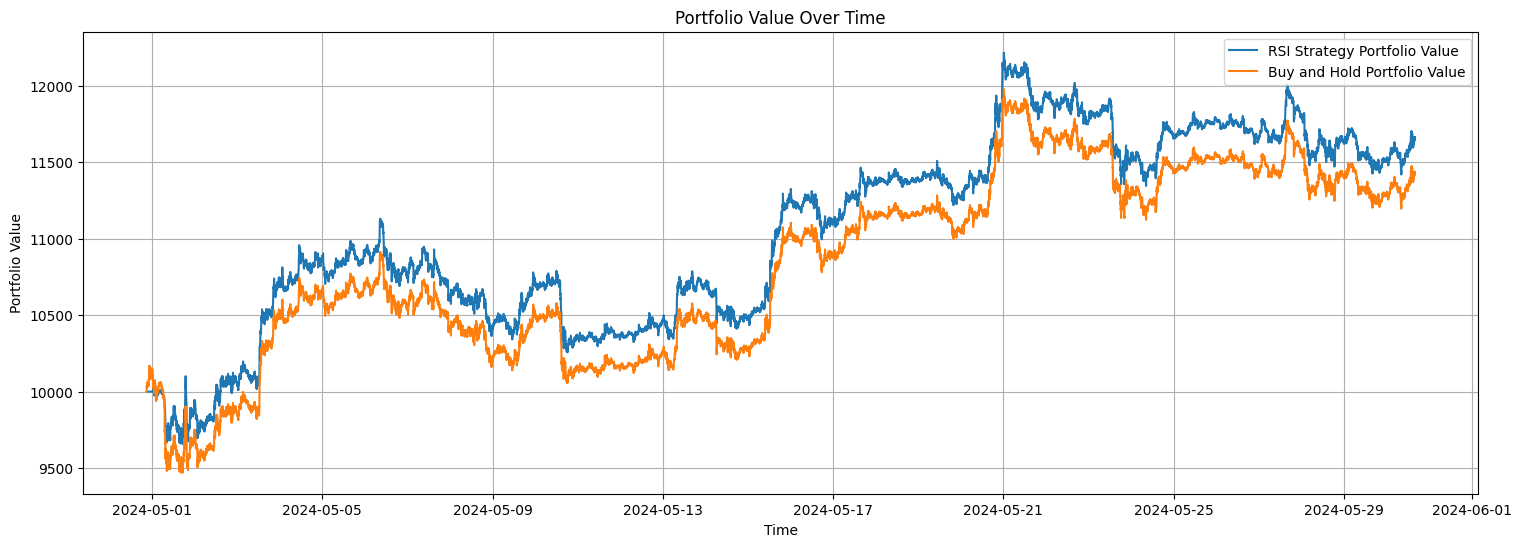

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000011    0.001082                 4.380559   
1  Buy and Hold        0.000010    0.001103                 3.783397   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.078545           0.166032      11660.316521  
1     -0.078545           0.143255      11432.551316

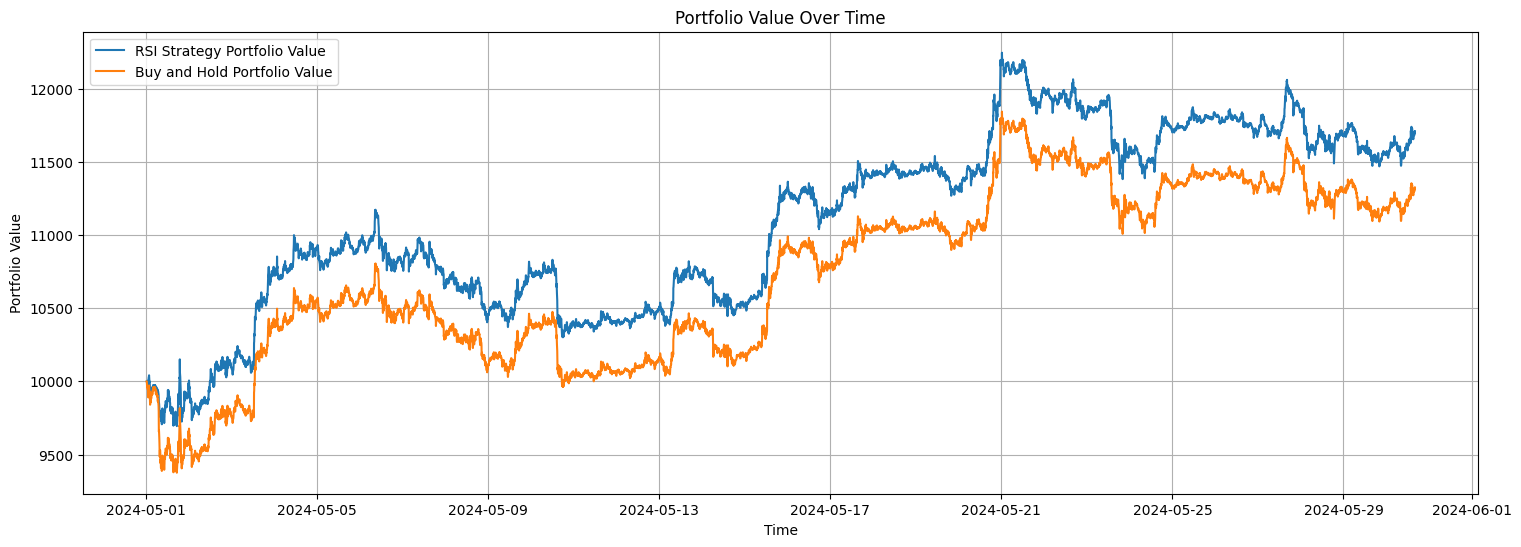

Strategy  Average Return  Volatility  Annualized Sharpe Ratio  \
0  RSI Strategy        0.000019    0.001391                 4.536116   
1  Buy and Hold        0.000016    0.001409                 3.581658   

   Max Drawdown  Cumulative Return  Portfolio amount  
0     -0.078068           0.171090      11710.903676  
1     -0.078068           0.132581      11325.807298

In [4]:
# Testing data

BTC_1m_op1_test = ordinary_rsi(BTC_1m_test, rsi_period = 35, ma_rsi = 14, rsi_lower_bound = 30, rsi_upper_bound = 85, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_1m_op1_test, timeframe = 1, starting_amount= 10000)

BTC_3m_op1_test = ordinary_rsi(BTC_3m_test, rsi_period = 28, ma_rsi = 14, rsi_lower_bound = 45, rsi_upper_bound = 85, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_3m_op1_test, timeframe = 3, starting_amount= 10000)

BTC_5m_op1_test = ordinary_rsi(BTC_5m_test, rsi_period = 26, ma_rsi = 14, rsi_lower_bound = 45, rsi_upper_bound = 90, sma_window = 100, mul_stoploss = 3, starting_amount = 10000, trading_fees = 0.05/100)
calculate_pm_st_1(BTC_5m_op1_test, timeframe = 5, starting_amount= 10000)